### Librerias

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoTokenizer
import pandas as pd
import torch
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score,f1_score,precision_score,mean_squared_error,roc_curve, roc_auc_score, r2_score,mean_absolute_error

### Cargar GPT

In [135]:
tokenizer = AutoTokenizer.from_pretrained('../Model/GPT-2/')
# Agrega el token de padding (si no existe)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    
# Cargar el modelo y el tokenizador
model = torch.load("../Model_Train/GPT_2_Fine_turned/GPT_2.pth")
model.resize_token_embeddings(len(tokenizer)) # Esencial para actualizar el modelo con el nuevo token
model.config.pad_token_id = tokenizer.pad_token_id
model.eval()

def classifySentiment(review_text):
    
    encoding = tokenizer.encode_plus(
        review_text,
        add_special_tokens=True,
        max_length=250,
        padding="max_length",
        return_token_type_ids=False,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )


    # Realizar la inferencia
    with torch.no_grad():  # Desactivar el cálculo de gradientes
        output = model(**encoding)
        logits = output.logits


    # Obtener la predicción
    #print(logits)
    _, prediction = torch.max(logits, dim=1)

    # Devolver la predicción como un valor escalar
    return prediction.item()

# Ejemplo de uso
print(classifySentiment("aunque ayer no tenían chuleton."))  # Debería devolver 0 o 1
print(classifySentiment("aunque ayer "))  # Debería devolver 0 o 1
print(classifySentiment("feliz"))  # Debería devolver 0 o 1

0
1
1


### Cargar BERT

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('../Model/bert-base-spanish-uncased/')
model = AutoModelForSequenceClassification.from_pretrained('../Model_Train/Beto_Fine_turned/')


def classifySentiment(review_text):
    encoding = tokenizer.encode_plus(
        review_text,
        add_special_tokens=True,
        max_length=250,
        padding="max_length",
        return_token_type_ids=False,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    

    # Mover los tensores al mismo dispositivo que el modelo
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Realizar la inferencia
    with torch.no_grad():  # Desactivar el cálculo de gradientes
        output = model(input_ids, attention_mask)
        logits = output.logits


    # Obtener la predicción
    #print(logits)
    _, prediction = torch.max(logits, dim=1)

    # Devolver la predicción como un valor escalar
    return prediction.item()

# Ejemplo de uso
print(classifySentiment("aunque ayer no tenían chuleton."))  # Debería devolver 0 o 1
print(classifySentiment("aunque ayer "))  # Debería devolver 0 o 1
print(classifySentiment("feliz"))  # Debería devolver 0 o 1

### Cargar Bertin

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('../Model/bertin-roberta-base-spanish/')
# Cargar el modelo y el tokenizador
model = torch.load("../Model_Train/Bertin_Base_Fine_turned/Bertin_Base.pth")
model.eval()

def classifySentiment(review_text):
    # Tokenizar la entrada
    encoding = tokenizer.encode_plus(
        review_text,
        add_special_tokens=True,
        max_length=250,
        padding="max_length",
        return_token_type_ids=False,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Mover los tensores al mismo dispositivo que el modelo
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Realizar la inferencia
    with torch.no_grad():  # Desactivar el cálculo de gradientes
        output = model(input_ids, attention_mask)
        logits = output.logits
        cls_logits = logits[:,0,:]

    # Obtener la predicción
    #print(cls_logits)
    #print(logits)
    _, prediction = torch.max(cls_logits, dim=1)
    #print(prediction)

    # Devolver la predicción como un valor escalar
    return prediction.item()

# Ejemplo de uso
print(classifySentiment("aunque ayer no tenían chuleton."))  # Debería devolver 0 o 1
print(classifySentiment("aunque ayer "))  # Debería devolver 0 o 1
print(classifySentiment("feliz"))  # Debería devolver 0 o 1

### Cargar Datos

In [77]:
df = pd.read_csv('../Preprocesing/SemEval_Test_Polarity_Ventana.csv', sep=';')
df_positivos = df[df['polarity']==1]
df_negativos = df[df['polarity']==0]
textos_pos = df_positivos['ventana']
textos_neg = df_negativos['ventana']

labels_true = df['polarity']
textos = list(df['ventana'])
df['polarity'].value_counts()

polarity
1    750
0    274
Name: count, dtype: int64

### Predecir

In [78]:
labels_pred = []
for texto in tqdm(textos):
    labels_pred.append(classifySentiment(texto))

100%|██████████| 1024/1024 [05:54<00:00,  2.89it/s]


### Metricas

In [79]:
accuracy = accuracy_score(labels_true, labels_pred)
precision = precision_score(labels_true, labels_pred)
recall = recall_score(labels_true, labels_pred)
f1 = f1_score(labels_true, labels_pred)
print("accuracy:" , accuracy)
print("precision:" , precision)
print("recall:" , recall)
print("f1:" , f1)

accuracy: 0.7919921875
precision: 0.8177514792899409
recall: 0.9213333333333333
f1: 0.8664576802507837


#### Matriz de Confusion

Text(0.5, 23.52222222222222, 'Valor Predicho')

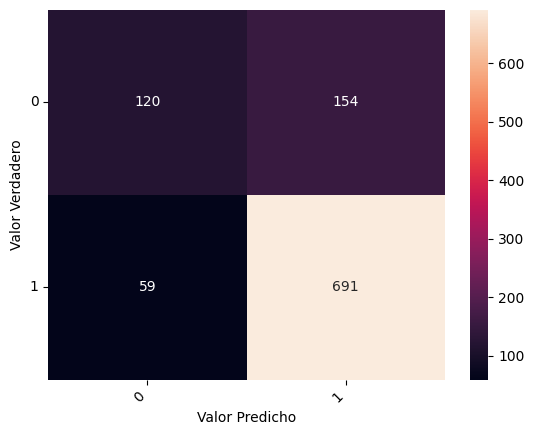

In [88]:
import matplotlib.pyplot as plt # Asegúrate de importar también Matplotlib
import seaborn as sns


df_cm = confusion_matrix(labels_true, labels_pred,labels=[0,1])
heatmap = sns.heatmap(df_cm,annot=True,fmt="d")
heatmap.yaxis.set_ticklabels([0,1],rotation=0,ha='right')
heatmap.xaxis.set_ticklabels([0,1],rotation=45,ha='right')
plt.ylabel('Valor Verdadero')
plt.xlabel('Valor Predicho')

#### Curva ROC

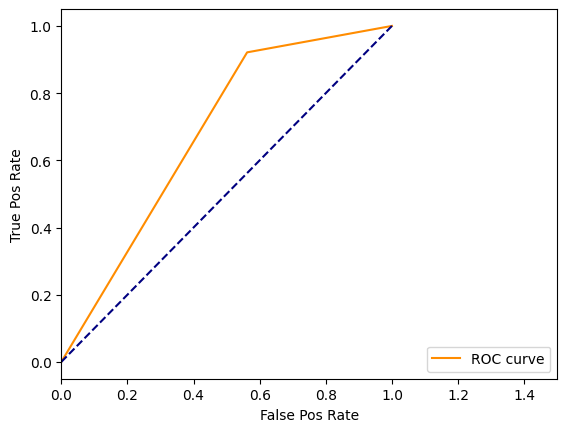

In [92]:
fpr, tpr, thresholds = roc_curve(labels_true,labels_pred)
plt.figure()
plt.plot(fpr,tpr,color='darkorange',label='ROC curve')
plt.plot([0,1],[0,1],color='navy',linestyle='--')
plt.xlim([0.0,1.0])
plt.xlim([0.0,1.5])
plt.xlabel('False Pos Rate')
plt.ylabel('True Pos Rate')
plt.legend(loc='lower right')
plt.show()


### Graficos

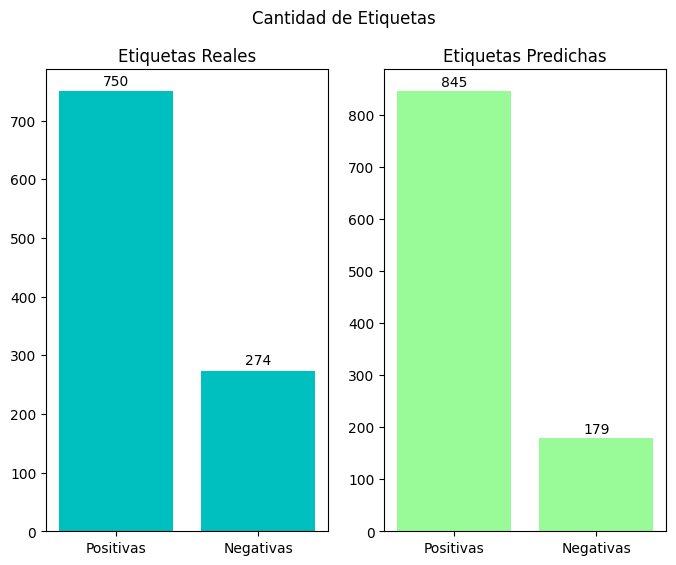

In [117]:
fig = plt.figure(figsize=[8,6])

names = ['Positivas', 'Negativas']
values = [sum(1 for x in labels_true if x == 1),sum(1 for x in labels_true if x == 0)]
values_2 = [labels_pred.count(1),labels_pred.count(0)]

ax = fig.add_subplot(121)
ax.bar(names, values,color='c')
ax.set_title("Etiquetas Reales")
for i in range(len(names)):
    plt.text(names[i],values[i]+10,str(values[i]),ha='center')

ax_2 = fig.add_subplot(122)
ax_2.bar(names, values_2, color='palegreen')
ax_2.set_title("Etiquetas Predichas")
for i in range(len(names)):
    plt.text(names[i],values_2[i]+10,str(values_2[i]),ha='center')

plt.suptitle("Cantidad de Etiquetas ")
plt.show()

### Nube de palabras

In [129]:
import nltk
nltk.download('stopwords') # Descarga las stopwords si aún no las tienes
from nltk.corpus import stopwords
from wordcloud import WordCloud


sw = set(stopwords.words('spanish'))
sw.add(',')
sw.add('2')
sw.add('3')

cleanPos = []
for sent in textos_pos:
    for word in sent.lower().split():
        if not word in sw:
            cleanPos.append(word)

cleanNeg = []
for sent in textos_neg:
    for word in sent.lower().split():
        if not word in sw:
            cleanNeg.append(word)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Miguel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
freq_dist_pos = nltk.FreqDist(cleanPos).most_common(20)
freq_dist_neg = nltk.FreqDist(cleanNeg).most_common(20)
terminos_relevantes = freq_dist_pos + freq_dist_neg
terminos_pos = [tupla[0] for tupla in freq_dist_pos]
terminos_neg = [tupla[0] for tupla in freq_dist_neg]

def color_func(word, font_size, position, orientation, random_state,**kwargs):
    if word in terminos_pos and word not in terminos_neg:
        return "green"
    elif word in terminos_neg and word not in terminos_pos:
        return "red"
    else:
        return "black"

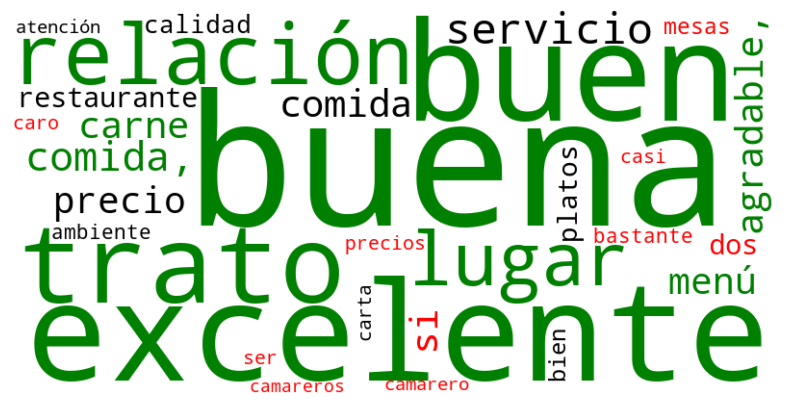

In [134]:
wordcloud = WordCloud(width=800,height=400, background_color="white", color_func=color_func).generate_from_frequencies(dict(terminos_relevantes))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()